# Intro
This is a demo for progress made towards theorem proving in `Catlab.jl`. This is based of work by Pawel S. such as https://arxiv.org/abs/2012.01847.

In [1]:
# Setup - can be ignored
include("/Users/ksb/Catlab.jl/test/atp/WD.jl"); 
using Catlab.Graphics: to_graphviz, Graphviz, LeftToRight

colors=Dict(:X=>"black", :O=>"blue", :A=>"red")
show_diagram(d::WiringDiagram; 
             w::Union{Vector{Pair{Int, String}}, Vector{String}}=String[], 
             i::Union{Vector{Pair{Int, String}}, Vector{String}}=String[], 
             o::Union{Vector{Pair{Int, String}}, Vector{String}}=String[]) = to_graphviz(
  label(d;w=w,i=i,o=o), orientation=LeftToRight, labels=true, label_attr=:xlabel,
  edge_attrs=Graphviz.Attributes(:fontname => "Courier"), junction_colors = colors,
  node_attrs=Graphviz.Attributes(:fontname => "Courier"))

function show_diagram(d::ACSet;
             w::Union{Vector{Pair{Int, String}}, Vector{String}}=String[],
             i::Union{Vector{Pair{Int, String}}, Vector{String}}=String[], 
             o::Union{Vector{Pair{Int, String}}, Vector{String}}=String[])
  show_diagram(cospan_to_wd(d); w=w,i=i,o=o)
end;


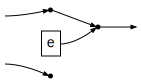

In [8]:
show_diagram(cancel.r)

In [ ]:
xnyymx = trim(@program(C, (x::X,n::X,m::X),
              let nx = mul(n,x); (nx,[mul(nx,m),x]) end), 1,1)
h, newres, r, r2 = prove(T_pcs_mon, xnyymx, passx; maxi=6)
println(h)
show_diagram(r2)

--------Iteration 1--------
applying mul_sv on I = [:V => 4, :mul => 2, :e => 0] and N = [:V => 0, :mul => 0, :e => 0]2 potential triggers (query time 1048 milliseconds)
time: 143 milliseconds
applying mul_assoc on I = [:V => 4, :mul => 2, :e => 0] and N = [:V => 0, :mul => 0, :e => 0]1 potential triggers (query time 7 milliseconds)
time: 444 milliseconds
applying e_intro on I = [:V => 4, :mul => 2, :e => 0] and N = [:V => 4, :mul => 2, :e => 0]1 potential triggers (query time 2 milliseconds)
time: 1 millisecond
applying cancel on I = [:V => 4, :mul => 2, :e => 0] and N = [:V => 5, :mul => 2, :e => 1]0 potential triggers (query time 4 milliseconds)
time: 0 milliseconds
applying e_sv on I = [:V => 4, :mul => 2, :e => 0] and N = [:V => 5, :mul => 2, :e => 1]0 potential triggers (query time 3 milliseconds)
time: 0 milliseconds
applying sym_rev on I = [:V => 4, :mul => 2, :e => 0] and N = [:V => 5, :mul => 2, :e => 1]2 potential triggers (query time 7 milliseconds)
time: 2 milliseconds
app

In [ ]:
idxxid = @program C (x::X) let y=e(); mul(mul(y, x), mul(x, y)) end
xx = @program C (x::X) mul(x, x) # final result
pr, res, m, res2 = prove(T_monoid, idxxid, xx; maxi=4)
show_diagram(res2)

In [ ]:
xnyymx = trim(@program(C, (x::X,n::X,m::X),
              let nx = mul(n,x); (nx,[mul(nx,m),x]) end), 1,1)
s = [:e_intro, :sym, :mul_assoc, :cancel, :pos, :leftid]
h, newres, r, r2 = prove(T_pcs_mon, xnyymx, passx; strat=seq([[ss] for ss in s]), maxi=length(s))
show_diagram(r2)

# Monoids
Generators for a theory are given by `Box` types. They have a symbol and a fixed number of inputs and outputs. We make terms with string diagrams, using generators and special commutative Frobenius algebra generators (ϵ, η, δ, μ). For example, `(e⋅x)⋅(x⋅e)`:

In [ ]:
show_diagram(idxxid; w=[3=>"x",4=>"x",5=>"e⋅x", 6=>"x⋅e"], i=["x"],o=["ex⋅xe"])


We can represent rewrite rules as pairs of terms. E.g. the left identity rule.

In [ ]:
show_diagram(leftid.l, i=["x"], o=["x"])

In [ ]:
show_diagram(leftid.r,i=["x"], o=["x"])

The rule gets applied to a term by substituting the left or right pattern (via DPO rewriting) with a branching term that includes both sides of the equation.

In [ ]:
merge_leftid = branch(leftid.l, leftid.r)[1]
show_diagram(merge_leftid, w=["x","","x","x","x"];i=["x"], o=["x"])

Connected components are collapsed to a single point when switching to the structured cospan of hypergraphs representation.

In [ ]:
show_diagram(wd_to_cospan(merge_leftid, Σ_monoid)[2];i=["x"])

Let's prove a monoid theorem. We know the `(e*x)*(x*e)` term above is equivalent to `x*x`, shown below:

In [ ]:
show_diagram(xx,i=["x"],o=["x⋅x"])

To prove these are equal, we apply the left and right identity rules to `(e*x)*(x*e)`:

In [ ]:
idxxid_sc       = wd_to_cospan(idxxid, Σ_monoid)[2] # initial state
applied_left_rw = apply_eq(idxxid_sc, T_monoid, :leftid);
show_diagram(applied_left_rw,w=[6=>"x",10=>"x⋅e"],i=["x"],o=["x⋅x"])

In [ ]:
applied_both_rw = apply_eq(applied_left_rw, T_monoid, :rightid);
show_diagram(applied_both_rw, i=["x"], o=["x⋅x"])

There was no homomorphism until both rewrites.

In [ ]:
xx_sc = wd_to_cospan(xx, Σ_monoid)[2] 
@assert !csp_homomorphic(xx_sc, idxxid_sc)
@assert !csp_homomorphic(xx_sc, applied_left_rw)
@assert  csp_homomorphic(xx_sc, applied_both_rw)

We can also apply the rewrites in the reverse direction to prove the other way. Furthermore we can naively apply all rewrite rules `n` times and check for homomorphisms as a basic automated theorem proving tactic .

In [ ]:
# Prove opposite direction
applied_left_rw = apply_eq(xx_sc,            T_monoid, :leftid;  n=-1, forward=false)
applied_both_rw = apply_eq(applied_left_rw,  T_monoid, :rightid; n=-1, forward=false)
@assert csp_homomorphic(idxxid_sc, applied_both_rw)

# Prove automatically given set of rules
result, _ = prove(T_monoid, idxxid, xx, n=1, oriented=true)
@assert result===true  # success

# Groups
To do interesting things with groups, we first need to prove that inverses are unique...

In [ ]:
show_diagram(wd_to_cospan(uniq_inv.l, T_group.gens)[2], i=["b","a","c"])

We will apply rewrites until this term has a homomorphism into the diagram (this proof is done step-by-step manually in a separate notebook).

In [ ]:
show_diagram(wd_to_cospan(uniq_inv.r, T_group.gens)[2], i=["b","a","c"])

Likewise we also would want to show `a*x=b` has the unique solution `x=a⁻¹*b` ...

In [ ]:
show_diagram(gdiv.l, i=["a","x","b"])

In [ ]:
show_diagram(gdiv.r, i=["a","x","b"])

... and that we can left-cancel.

In [ ]:
show_diagram(leftcancel.l, w=[3=>"a⋅b",4=>"a⋅c"],i=["a","b","c"])

In [ ]:
show_diagram(leftcancel.r,i=["a","b","c"])

# Dihedral groups
There are two typical ways to present dihedral groups, which are generated by elements `r` and `s` with order `n` and `2`, respectively. Let `n=3`.

In [ ]:
# an axiom asserts this is equal to the group unit element, e
show_diagram(r_order_3.l,w=[5=>"r", 6=>"r²"], o=["r³"]) 

There is one more axiom, typically stated as `srs⁻¹=r⁻¹` or `(sr)²=1`. If we can show these two expressions imply each other, we'll have shown the corresponding presentations are equal.

We can prove one direction by the following chain: `(sr)² = srsr = (srs⁻¹)r = (r⁻¹)r = 1`. We benefit from knowing `s=s⁻¹`, which can be proven by left cancellation applied to `s*s=s*s⁻¹` (this is relatively close to our axioms).

# Multisorted, partial theories 

Reference: Functorial Semantics for Parital theories https://arxiv.org/abs/2011.06644
We can give each vertex a color attribute which must be preserved by homomorphisms. For example, the `refl; src = id` for reflexive graphs is stated by the following diagrams, where blue = object and red=arrow: 

In [ ]:
# An axiom states this is equal to a blue passthrough wire.
show_diagram(wd_to_cospan(refls.l, T_reflG.gens)[2])

The introduction rule for composition forces source and target to be equal.

In [ ]:
show_diagram(wd_to_cospan(cmp_intro.l, T_cat.gens)[2])

In [ ]:
show_diagram(wd_to_cospan(cmp_intro.r, T_cat.gens)[2])

We can continue all the way to cartesian closed categories, with equations such as: given a $g:X\rightarrow[A,B]$, then $\lambda(X,A,B,(g\times 1);ev)=g$. This is expressed by the following pair of diagrams:

In [ ]:
show_diagram(wd_to_cospan(lam_eqg.l, T_ccc.gens)[2])

In [ ]:
show_diagram(wd_to_cospan(lam_eqg.r, T_ccc.gens)[2])